# **Plants Seedling Classification**

## Description

Background and Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

## Objective

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species. You being a data scientist, need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

## Goal

The goal of the project is to create a classifier capable of determining a plant's species from an image.

### **Importing the necessary libraries**

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### **Load Files**

In [2]:
# Connect to the google drive
from google.colab import drive
drive.mount('/content/gdrive.py', force_remount=True) 

Mounted at /content/gdrive.py


In [3]:
cd '/content'

/content


In [4]:
cd 'gdrive.py/'

/content/gdrive.py


In [5]:
cd 'MyDrive/'

/content/gdrive.py/MyDrive


In [6]:
cd 'Colab Notebooks/Module 8/Project/'

/content/gdrive.py/MyDrive/Colab Notebooks/Module 8/Project


In [7]:
# Load the image file of the dataset
images = np.load('images.npy')

In [8]:
#Load Labels from file
labels = pd.read_csv('Labels.csv')

### **Overview of Dataset**

In [9]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


* There are 4750 separate images.
* The size of the images are 128x128 pixels.
* They are broken out into 3 color channels.

### **Plotting Images**

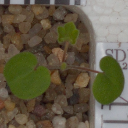

In [10]:
cv2_imshow(images[2])

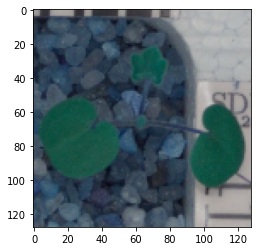

In [11]:
plt.imshow(images[2])

* The colors look different between the two images


In [12]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### **Exploratory Data Analysis**

In [13]:
# Show 12 random images from the dataset
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

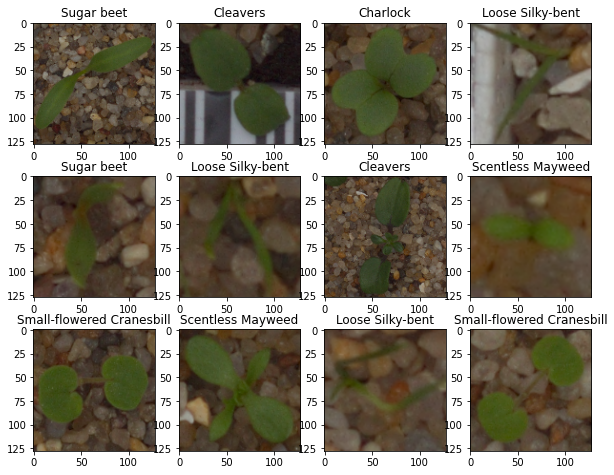

In [14]:
plot_images(images,labels)

#### **Check data balance**


In [15]:
#Show unique list of plants.
labels["Label"].unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

* There are no nulls in the data

In [16]:
#Print Labels and their counts for each of the 12 classes.
labels["Label"].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

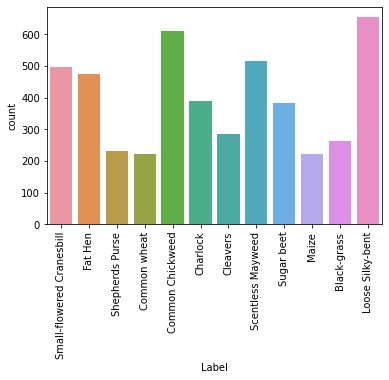

In [17]:
#Show graph of the 12 plant classes and how many images of each we have.
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')

* There are about 3 times as many Common Chickweed and Loose Silky bent as there are Shephards Purse, Common Wheat, Maize, and Black grass.  
* The top two classes Loose Silky-bent and Common Chickweed account for nearly 27% of the image data.
It may be necessary to balance the classes through augmentation (for example).

## **Data Preprocessing**

### **Remove Noise and Reduce Image Size**

#### **Reduce Image Size**

In [18]:
#Decrease the size of the image by half
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

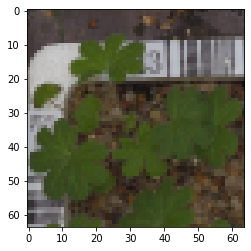

In [19]:
plt.imshow(images_decreased[3])

#### **Visualizing images using Gaussian Blur**

In [20]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))

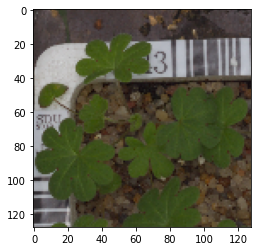

In [21]:
plt.imshow(images[3])

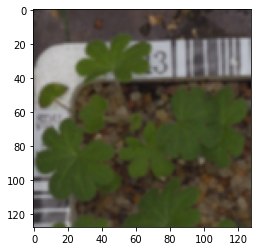

In [22]:
plt.imshow(images_gb[3])

* The blurring appears to make the stones on the ground less pronounced.  This is beneficial in identifying plants from the background noise.

##  **Splitting the dataset**

Since there is a reasonable amount of data, I will use abut 20% of the data for test and approximately 16% for validation.

In [23]:
#Split the data into train, validation, and test datasets
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_gb),labels , test_size=0.2, random_state=1,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.2, random_state=1,stratify=y_temp)

### **Encoding the target labels**

In [24]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder 

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### **Data Normalization**

In [25]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [26]:
#Before normalizing and encoding the data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3040, 128, 128, 3) (3040, 1)
(760, 128, 128, 3) (760, 1)
(950, 128, 128, 3) (950, 1)


In [27]:
#After normalizing and encoding the data
print(X_train_normalized.shape,y_train_encoded.shape)
print(X_val_normalized.shape,y_val_encoded.shape)
print(X_test_normalized.shape,y_test_encoded.shape)

(3040, 128, 128, 3) (3040, 12)
(760, 128, 128, 3) (760, 12)
(950, 128, 128, 3) (950, 12)


In [28]:
#View normalized Data
X_train_normalized[0]

array([[[0.1882353 , 0.16078432, 0.13725491],
        [0.18039216, 0.15294118, 0.12941177],
        [0.17254902, 0.14117648, 0.11764706],
        ...,
        [0.29803923, 0.21960784, 0.15294118],
        [0.29411766, 0.21176471, 0.14117648],
        [0.28627452, 0.20392157, 0.13725491]],

       [[0.1882353 , 0.15294118, 0.12156863],
        [0.18039216, 0.14509805, 0.11372549],
        [0.16862746, 0.12941177, 0.09411765],
        ...,
        [0.28235295, 0.2       , 0.12941177],
        [0.28235295, 0.2       , 0.12941177],
        [0.2784314 , 0.19215687, 0.1254902 ]],

       [[0.22745098, 0.18431373, 0.13333334],
        [0.20784314, 0.16078432, 0.10980392],
        [0.1764706 , 0.1254902 , 0.07058824],
        ...,
        [0.25882354, 0.1764706 , 0.10588235],
        [0.26666668, 0.18039216, 0.10980392],
        [0.26666668, 0.18039216, 0.10980392]],

       ...,

       [[0.24313726, 0.19215687, 0.15686275],
        [0.24313726, 0.19215687, 0.15686275],
        [0.23921569, 0

* The features have been normalized to values from 0 to 1.  
* Target variable has been encoded from one column to 12 columns - one for each of the 12 classes.

## **Model 1**

I will start with a basic CNN model as a baseline for data with Guasian Blur applied.

In [29]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [30]:
# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

### **Model Definition**

In [31]:
#Model Definition
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3), padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())

cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())

cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))

cnn_model.add(Flatten())

cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25))

cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.25))

cnn_model.add(Dense(32, activation='relu'))

# adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem with 3 classes.
cnn_model.add(Dense(12, activation = "softmax"))

In [32]:
#Compile Model
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                        

### **Fitting the model on the train data**

In [34]:
#fit the model
history_1 = cnn_model.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64, #increase to see if it changes anything
            verbose=2
)

Epoch 1/50
48/48 - 6s - loss: 0.4496 - accuracy: 0.1309 - val_loss: 0.5348 - val_accuracy: 0.1382 - 6s/epoch - 119ms/step
Epoch 2/50
48/48 - 1s - loss: 0.2702 - accuracy: 0.2961 - val_loss: 0.3635 - val_accuracy: 0.1382 - 1s/epoch - 29ms/step
Epoch 3/50
48/48 - 1s - loss: 0.2226 - accuracy: 0.4451 - val_loss: 0.3462 - val_accuracy: 0.1395 - 1s/epoch - 29ms/step
Epoch 4/50
48/48 - 1s - loss: 0.1989 - accuracy: 0.5020 - val_loss: 0.3856 - val_accuracy: 0.1382 - 1s/epoch - 29ms/step
Epoch 5/50
48/48 - 1s - loss: 0.1803 - accuracy: 0.5579 - val_loss: 0.5752 - val_accuracy: 0.1382 - 1s/epoch - 29ms/step
Epoch 6/50
48/48 - 1s - loss: 0.1694 - accuracy: 0.5803 - val_loss: 0.6073 - val_accuracy: 0.1382 - 1s/epoch - 29ms/step
Epoch 7/50
48/48 - 1s - loss: 0.1505 - accuracy: 0.6470 - val_loss: 0.8531 - val_accuracy: 0.1382 - 1s/epoch - 29ms/step
Epoch 8/50
48/48 - 1s - loss: 0.1377 - accuracy: 0.6750 - val_loss: 0.7679 - val_accuracy: 0.1382 - 1s/epoch - 29ms/step
Epoch 9/50
48/48 - 1s - loss: 0

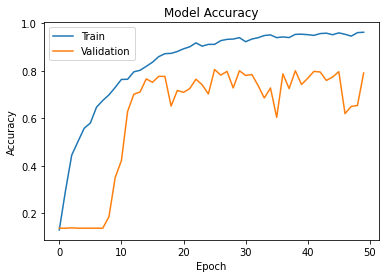

In [35]:
#Plot performance of train and test datasets
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* The model is actually performing pretty well but is noisy and overfit.

In [36]:
#Evaluate Model on Train data
accuracy = cnn_model.evaluate(X_train_normalized, y_train_encoded, verbose=2)

95/95 - 1s - loss: 0.0016 - accuracy: 0.9984 - 811ms/epoch - 9ms/step


In [37]:
#evaluate Model on Test data
accuracy = cnn_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 0s - loss: 0.1750 - accuracy: 0.7642 - 279ms/epoch - 9ms/step


In [38]:
#Generate Prediction using test data
y_pred=cnn_model.predict(X_test_normalized)

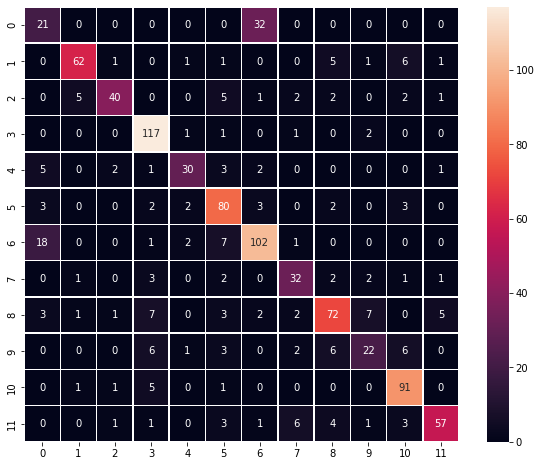

In [39]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
#ax.xaxis.set_ticklabels(CATEGORIES); ax.yaxis.set_ticklabels(CATEGORIES);
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [40]:
#Check Precision, Recall, F1-Score
from sklearn.metrics import classification_report
print(classification_report((y_test_arg), y_pred_arg))

              precision    recall  f1-score   support

           0       0.42      0.40      0.41        53
           1       0.89      0.79      0.84        78
           2       0.87      0.69      0.77        58
           3       0.82      0.96      0.88       122
           4       0.81      0.68      0.74        44
           5       0.73      0.84      0.78        95
           6       0.71      0.78      0.74       131
           7       0.70      0.73      0.71        44
           8       0.77      0.70      0.73       103
           9       0.63      0.48      0.54        46
          10       0.81      0.92      0.86        99
          11       0.86      0.74      0.80        77

    accuracy                           0.76       950
   macro avg       0.75      0.73      0.73       950
weighted avg       0.76      0.76      0.76       950



* Predictions are generally descent with an F1 Score of about .76 and an accuracy rate of .76 on the test dataset.
* The model seems to confuse Class 0 and Class 6 somewhat frequently.  
* It varies from Class to Class, but overall Recall and Precision appear to be performing relatively similarly with precision having a slight edge.

## **Model 2**

I will try the same CNN model as Model 1 but with images that are reduced in size rather than Guasian Blur to see if it may perform better.

### **Splitting the dataset "decreased"**

In [41]:
#Split the dataset into train, validation, and test data sets to be used with the image_decreased dataset to see if images
#decreased in size will perform better than the guasian blur dataset.
from sklearn.model_selection import train_test_split
X_temp_decreased, X_test_decreased, y_temp_decreased, y_test_decreased = train_test_split(np.array(images_decreased),labels , test_size=0.2, random_state=1,stratify=labels)
X_train_decreased, X_val_decreased, y_train_decreased, y_val_decreased = train_test_split(X_temp_decreased,y_temp_decreased , test_size=0.2, random_state=1,stratify=y_temp_decreased)

### **Encoding the target labels "decreased"**

In [42]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder 

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded_decreased = enc.fit_transform(y_train_decreased)
y_val_encoded_decreased=enc.transform(y_val_decreased)
y_test_encoded_decreased=enc.transform(y_test_decreased)

### **Data Normalization "decreased"**

In [43]:
# Normalizing the image pixels
X_train_normalized_decreased = X_train_decreased.astype('float32')/255.0
X_val_normalized_decreased = X_val_decreased.astype('float32')/255.0
X_test_normalized_decreased = X_test_decreased.astype('float32')/255.0

### **Build Model "decreased"**

In [44]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [45]:
# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [46]:
#Define Model with decreased image size data
cnn_model_decreased = Sequential()

cnn_model_decreased.add(Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
cnn_model_decreased.add(MaxPooling2D(2,2))
cnn_model_decreased.add(BatchNormalization())

cnn_model_decreased.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model_decreased.add(MaxPooling2D(2,2))
cnn_model_decreased.add(BatchNormalization())

cnn_model_decreased.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model_decreased.add(MaxPooling2D(2,2))

cnn_model_decreased.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))

cnn_model_decreased.add(Flatten())

cnn_model_decreased.add(Dense(64, activation='relu'))
cnn_model_decreased.add(Dropout(0.25))

cnn_model_decreased.add(Dense(32, activation='relu'))
cnn_model_decreased.add(Dropout(0.25))

cnn_model_decreased.add(Dense(32, activation='relu'))

# adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem with 3 classes.
cnn_model_decreased.add(Dense(12, activation = "softmax"))

In [47]:
#Compile Model
cnn_model_decreased.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_model_decreased.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                        

### **Fit Model "decreased"**

In [48]:
#Fit model
history_1_decreased = cnn_model_decreased.fit(
            X_train_normalized_decreased, y_train_encoded_decreased,
            epochs=50, 
            validation_data=(X_val_normalized_decreased,y_val_encoded_decreased),
            batch_size=64, #increase to see if it changes anything
            verbose=2
)

Epoch 1/50
48/48 - 2s - loss: 0.4521 - accuracy: 0.1158 - val_loss: 0.5676 - val_accuracy: 0.1276 - 2s/epoch - 38ms/step
Epoch 2/50
48/48 - 0s - loss: 0.2903 - accuracy: 0.2109 - val_loss: 0.4507 - val_accuracy: 0.1053 - 448ms/epoch - 9ms/step
Epoch 3/50
48/48 - 0s - loss: 0.2425 - accuracy: 0.3641 - val_loss: 0.3840 - val_accuracy: 0.1382 - 451ms/epoch - 9ms/step
Epoch 4/50
48/48 - 0s - loss: 0.2106 - accuracy: 0.4602 - val_loss: 0.3238 - val_accuracy: 0.0737 - 466ms/epoch - 10ms/step
Epoch 5/50
48/48 - 0s - loss: 0.1884 - accuracy: 0.5257 - val_loss: 0.3743 - val_accuracy: 0.1263 - 477ms/epoch - 10ms/step
Epoch 6/50
48/48 - 0s - loss: 0.1709 - accuracy: 0.5717 - val_loss: 0.3707 - val_accuracy: 0.1382 - 448ms/epoch - 9ms/step
Epoch 7/50
48/48 - 0s - loss: 0.1537 - accuracy: 0.6405 - val_loss: 0.4313 - val_accuracy: 0.1224 - 443ms/epoch - 9ms/step
Epoch 8/50
48/48 - 0s - loss: 0.1442 - accuracy: 0.6530 - val_loss: 0.2751 - val_accuracy: 0.2421 - 460ms/epoch - 10ms/step
Epoch 9/50
48/4

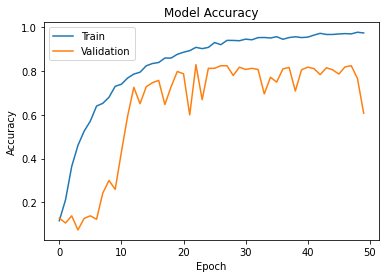

In [49]:
#plot model performance
plt.plot(history_1_decreased.history['accuracy'])
plt.plot(history_1_decreased.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [50]:
#Evaluate Model on Train data
accuracy = cnn_model_decreased.evaluate(X_train_normalized_decreased, y_train_encoded_decreased, verbose=2)

95/95 - 1s - loss: 0.1394 - accuracy: 0.7655 - 512ms/epoch - 5ms/step


In [51]:
#evaluate Model on Test data
accuracy = cnn_model_decreased.evaluate(X_test_normalized_decreased, y_test_encoded_decreased, verbose=2)

30/30 - 0s - loss: 0.3026 - accuracy: 0.6021 - 205ms/epoch - 7ms/step


In [52]:
#Generate Prediction using test data
y_pred_decreased=cnn_model_decreased.predict(X_test_normalized_decreased)

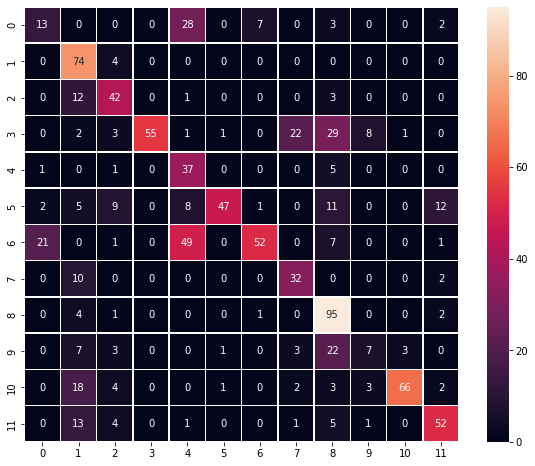

In [53]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_decreased=np.argmax(y_pred_decreased,axis=1)
y_test_arg_decreased=np.argmax(y_test_encoded_decreased,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg_decreased,y_pred_arg_decreased)
f, ax = plt.subplots(figsize=(10, 8))
#ax.xaxis.set_ticklabels(CATEGORIES); ax.yaxis.set_ticklabels(CATEGORIES);
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [54]:
#Check Precision, Recall, F1-Score
from sklearn.metrics import classification_report
print(classification_report((y_test_arg_decreased), y_pred_arg_decreased))

              precision    recall  f1-score   support

           0       0.35      0.25      0.29        53
           1       0.51      0.95      0.66        78
           2       0.58      0.72      0.65        58
           3       1.00      0.45      0.62       122
           4       0.30      0.84      0.44        44
           5       0.94      0.49      0.65        95
           6       0.85      0.40      0.54       131
           7       0.53      0.73      0.62        44
           8       0.52      0.92      0.66       103
           9       0.37      0.15      0.22        46
          10       0.94      0.67      0.78        99
          11       0.71      0.68      0.69        77

    accuracy                           0.60       950
   macro avg       0.63      0.60      0.57       950
weighted avg       0.71      0.60      0.60       950



* The performance of the reduced image size is significantly worse than the Guasian Blur image performance.  Guasian Blur got a score of 76% accuracy while the accuracy of Decreased Image Size is 60%.  
* In subsequent models, I will use the Gausian Blurr image dataset as it performs best.
* Here numerous classes appear to be performing poorly.
* The weighted precision is much better than the Weighted recall but the Macro Precision and Recall are relatively similar in performance.

## **Model 3**

Lets try to use weights to balance the data and see if that improves performance. I will also try to tweek learning rate, tweek nueron numbers, epoch number, and try SGD activiation function.  I intended to use Guasian Blur on this model but found that the performance was significantly better on this model with a Decreased Image than with the Guasian Blur.  I will apply Decreased Image for this model.

In [75]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [76]:
# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

### **Model Definition**

In [77]:
#Define model for class weight balanced model
cnn_model_bal = Sequential()
cnn_model_bal.add(Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
cnn_model_bal.add(MaxPooling2D(2,2))
cnn_model_bal.add(BatchNormalization())

cnn_model_bal.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
cnn_model_bal.add(MaxPooling2D(2,2))
cnn_model_bal.add(BatchNormalization())

cnn_model_bal.add(Conv2D(128, (3,3), activation='relu', padding = 'same'))
cnn_model_bal.add(MaxPooling2D(2,2))

cnn_model_bal.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))

cnn_model_bal.add(Flatten())

cnn_model_bal.add(Dense(64, activation='relu'))
cnn_model_bal.add(Dropout(0.25))

cnn_model_bal.add(Dense(32, activation='relu'))
cnn_model_bal.add(Dropout(0.25))

cnn_model_bal.add(Dense(32, activation='relu'))
# adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem with 3 classes.
cnn_model_bal.add(Dense(12, activation = "softmax"))

In [78]:
#Compile Model
epochs = 100 #Run for 100 epochs
learning_rate = 0.125 #Defining learning rate
decay_rate = learning_rate / epochs
momentum = 0.7 #Set momentum
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
#adam = Adam(learning_rate=learning_rate)

cnn_model_bal.compile(loss="binary_crossentropy", optimizer=sgd, metrics = ['accuracy'])
cnn_model_bal.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                        

### **Fit Model**

In [79]:
from sklearn.utils import class_weight

#Return values needed to balance the weights for classes that are not balanced.
labelList = labels["Label"].unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights


{0: 0.7966457023060797,
 1: 0.8333333333333334,
 2: 1.7117117117117118,
 3: 1.784037558685446,
 4: 0.6479113384484229,
 5: 1.0133333333333334,
 6: 1.384335154826958,
 7: 0.7676767676767676,
 8: 1.029810298102981,
 9: 1.784037558685446,
 10: 1.507936507936508,
 11: 0.6060606060606061}

In [80]:
history_1_bal = cnn_model_bal.fit(
            X_train_normalized_decreased, y_train_encoded_decreased,
            epochs=100,
            validation_data=(X_val_normalized_decreased,y_val_encoded_decreased),
            batch_size=128,
            class_weight=class_weights, #Applying Class Weights
            verbose=2
)

Epoch 1/100
24/24 - 2s - loss: 0.4613 - accuracy: 0.1260 - val_loss: 0.5640 - val_accuracy: 0.1289 - 2s/epoch - 103ms/step
Epoch 2/100
24/24 - 1s - loss: 0.3299 - accuracy: 0.2184 - val_loss: 0.4966 - val_accuracy: 0.1382 - 525ms/epoch - 22ms/step
Epoch 3/100
24/24 - 1s - loss: 0.2995 - accuracy: 0.2859 - val_loss: 0.4258 - val_accuracy: 0.1382 - 535ms/epoch - 22ms/step
Epoch 4/100
24/24 - 1s - loss: 0.2788 - accuracy: 0.3211 - val_loss: 0.3655 - val_accuracy: 0.1382 - 528ms/epoch - 22ms/step
Epoch 5/100
24/24 - 1s - loss: 0.2580 - accuracy: 0.3566 - val_loss: 0.3565 - val_accuracy: 0.1382 - 531ms/epoch - 22ms/step
Epoch 6/100
24/24 - 1s - loss: 0.2365 - accuracy: 0.3987 - val_loss: 0.3885 - val_accuracy: 0.1382 - 534ms/epoch - 22ms/step
Epoch 7/100
24/24 - 1s - loss: 0.2233 - accuracy: 0.4240 - val_loss: 0.4418 - val_accuracy: 0.1382 - 543ms/epoch - 23ms/step
Epoch 8/100
24/24 - 1s - loss: 0.2147 - accuracy: 0.4586 - val_loss: 0.4785 - val_accuracy: 0.1382 - 529ms/epoch - 22ms/step
Ep

### **Model Evaluation**

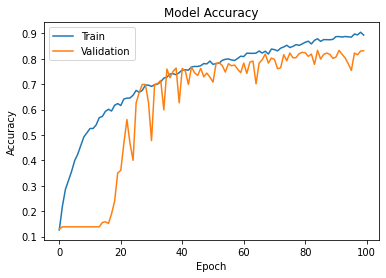

In [81]:
#Plot performance of validation and train data
plt.plot(history_1_bal.history['accuracy'])
plt.plot(history_1_bal.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* The validation set is relatively noisy by comparison to the train model performance. 
* It doesnt look like we are getting improvement after about 60-70 epochs.

In [82]:
#Evaluate the model on Train data
accuracy_bal = cnn_model_bal.evaluate(X_train_normalized_decreased, y_train_encoded_decreased, verbose=2)

95/95 - 1s - loss: 0.0239 - accuracy: 0.9536 - 555ms/epoch - 6ms/step


In [83]:
#Evaluate model performance on test data
accuracy_bal = cnn_model_bal.evaluate(X_test_normalized_decreased, y_test_encoded_decreased, verbose=2)

30/30 - 0s - loss: 0.0951 - accuracy: 0.8189 - 220ms/epoch - 7ms/step


In [84]:
#predict result on test
y_pred_bal=cnn_model_bal.predict(X_test_normalized_decreased)

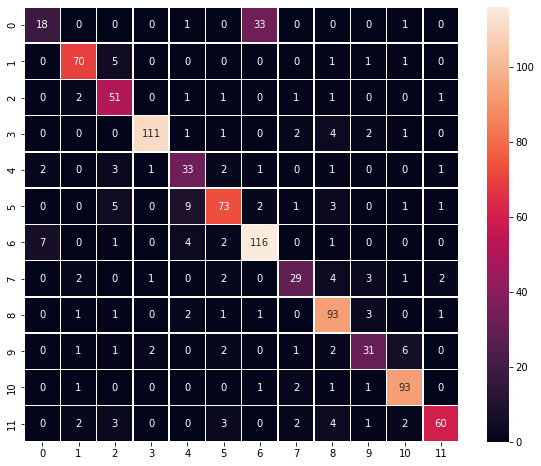

In [85]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_bal=np.argmax(y_pred_bal,axis=1)
y_test_arg=np.argmax(y_test_encoded_decreased,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg_bal)
f, ax = plt.subplots(figsize=(10, 8))
#ax.xaxis.set_ticklabels(CATEGORIES); ax.yaxis.set_ticklabels(CATEGORIES);
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [86]:
#Check Precision, Recall, F1-Score
from sklearn.metrics import classification_report
print(classification_report((y_test_arg), y_pred_arg_bal))

              precision    recall  f1-score   support

           0       0.67      0.34      0.45        53
           1       0.89      0.90      0.89        78
           2       0.73      0.88      0.80        58
           3       0.97      0.91      0.94       122
           4       0.65      0.75      0.69        44
           5       0.84      0.77      0.80        95
           6       0.75      0.89      0.81       131
           7       0.76      0.66      0.71        44
           8       0.81      0.90      0.85       103
           9       0.74      0.67      0.70        46
          10       0.88      0.94      0.91        99
          11       0.91      0.78      0.84        77

    accuracy                           0.82       950
   macro avg       0.80      0.78      0.78       950
weighted avg       0.82      0.82      0.81       950



* The overall accuracy on this model is the best so far at nearly 82%.
* The model validation and Training performance is moving very closely together indicating good generalization of the model.
* Performance looks to have peaked around 60-70 epochs and continuing to add additional epochs does not improve performance.
* Here the weighted average between recall and precision is the same at 82% but the macros average performs slightly better on precision by 2%.
* The model is better at identifying Class 6 correctly but Class 0 is still being mistaken for Class 6 very often.

## **Model 4**

I will see if we can get any performance gain using Augmentation and Transfer Learning (VGG16).  I will reuse the same dense output layer.  Since I had good results with the Decreased Image size in Model 3, I will reuse that here as well as Class Weights.

When I ran this for the tuned SGD optimizer on the model below, I got weird results (validation was stuck at 12% across all epochs).  I will apply Adam Optimizer here with default parameter settings.

In this model I will attempt to perform data augmentation and transfer learning to see if it improves model performance.

In [103]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [104]:
# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [105]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                              fill_mode='nearest'
                              )


In [106]:
# Importing all the required sub-modules from Keras
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [107]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [108]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [109]:
#Set Model Definition including VGG for the Convolution layer
vgg_aug_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
vgg_aug_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
vgg_aug_model.add(Flatten())

# Adding a dense output layer
vgg_aug_model.add(Flatten())
vgg_aug_model.add(Dense(64, activation='relu'))
vgg_aug_model.add(Dropout(0.25))
vgg_aug_model.add(Dense(32, activation='relu'))
vgg_aug_model.add(Dropout(0.25))
vgg_aug_model.add(Dense(32, activation='relu'))
# adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem with 3 classes.
vgg_aug_model.add(Dense(12, activation = "softmax"))

In [110]:
#Compile model 
# I tried this model with various parameter tweeking and found it only worsened performance.
epochs = 70
learning_rate = 0.8
decay_rate = learning_rate / epochs
momentum = 0.7
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
adam = Adam(learning_rate=learning_rate)

# Compile model - using adam because I got strange results with SGD optimizer on this model
vgg_aug_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
vgg_aug_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [111]:
# Set Batch size
batch_size = 64
# Fit model
history_vgg16 = vgg_aug_model.fit(train_datagen.flow(X_train_normalized_decreased,y_train_encoded_decreased,
                                       batch_size=batch_size, 
                                       seed=1,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized_decreased.shape[0] // batch_size,
                    validation_data=(X_val_normalized_decreased,y_val_encoded_decreased),
                    class_weight=class_weights, #Applying Class Weights
                    verbose=1)
                                  


Epoch 1/70
47/47 [==============================] - 5s 91ms/step - loss: 2.8511 - accuracy: 0.1415 - val_loss: 2.3240 - val_accuracy: 0.2447
Epoch 2/70
47/47 [==============================] - 4s 84ms/step - loss: 2.5878 - accuracy: 0.2319 - val_loss: 2.1009 - val_accuracy: 0.2776
Epoch 3/70
47/47 [==============================] - 4s 84ms/step - loss: 2.3660 - accuracy: 0.2678 - val_loss: 1.9261 - val_accuracy: 0.3224
Epoch 4/70
47/47 [==============================] - 4s 84ms/step - loss: 2.1915 - accuracy: 0.3112 - val_loss: 1.7971 - val_accuracy: 0.3658
Epoch 5/70
47/47 [==============================] - 4s 83ms/step - loss: 2.0975 - accuracy: 0.3229 - val_loss: 1.6967 - val_accuracy: 0.3974
Epoch 6/70
47/47 [==============================] - 4s 84ms/step - loss: 1.9854 - accuracy: 0.3575 - val_loss: 1.6101 - val_accuracy: 0.4263
Epoch 7/70
47/47 [==============================] - 4s 86ms/step - loss: 1.9491 - accuracy: 0.3639 - val_loss: 1.6345 - val_accuracy: 0.3895
Epoch 8/70
47

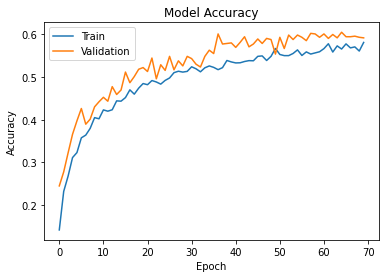

In [114]:
#Plot Training and Test performance of model
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [116]:
#Return Train accuracy
accuracy = vgg_aug_model.evaluate(X_train_normalized_decreased, y_train_encoded_decreased, verbose=2)

95/95 - 2s - loss: 0.9700 - accuracy: 0.6385 - 2s/epoch - 17ms/step


In [117]:
#Return test accuracy
accuracy = vgg_aug_model.evaluate(X_test_normalized_decreased, y_test_encoded_decreased, verbose=2)

30/30 - 1s - loss: 1.2426 - accuracy: 0.5558 - 917ms/epoch - 31ms/step


In [118]:
# Here we would get the output as probablities for each category
y_pred_vgg=vgg_aug_model.predict(X_test_normalized_decreased)

In [119]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_vgg=np.argmax(y_pred_vgg,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

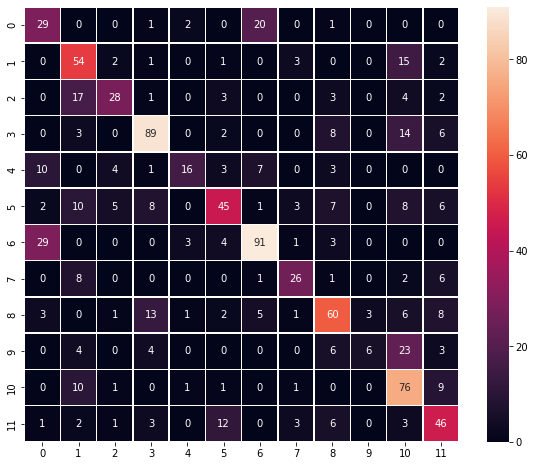

In [81]:

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg_vgg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [120]:
#Check Precision, Recall, F1-Score
from sklearn.metrics import classification_report
print(classification_report((y_test_arg), y_pred_arg_vgg))

              precision    recall  f1-score   support

           0       1.00      0.04      0.07        53
           1       0.58      0.44      0.50        78
           2       0.66      0.60      0.63        58
           3       0.58      0.81      0.67       122
           4       1.00      0.05      0.09        44
           5       0.56      0.32      0.40        95
           6       0.56      0.95      0.71       131
           7       0.55      0.55      0.55        44
           8       0.61      0.54      0.57       103
           9       0.30      0.22      0.25        46
          10       0.46      0.85      0.60        99
          11       0.74      0.36      0.49        77

    accuracy                           0.56       950
   macro avg       0.63      0.48      0.46       950
weighted avg       0.61      0.56      0.51       950



* The model is actually looking like it is not overfitting.  However, the performance is significantly worse than any of the other models with an accuracy rate of just 56% on the test dataset.
* Class 9 is performing especially poorly with an F1 Score of only .25.  It is not surprise however considering class 9 (and class 3) had only 221 images in the dataset - the lowest number of images in the entire dataset.  The model performance on Class 9 may just be suffering from insufficient data for that class.
* Here again, precision is better than recall.

In [121]:
#Show Model Summary for original Model 1
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                        

In [122]:
#Show Model Summary for weight balanced Model 3
cnn_model_bal.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                        

In [123]:
#Show summary of VGG Model 4
vgg_aug_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

## **Conclusion**

* The class imbalance is creating accuracy issues.  We could see that balancing class weights in Model 3 significantly improved performance.  However it appeared to do nothing for Model 4.
* Maize is one of our poorest performing classifications across all 4 models.  It is also one of our two smallest data samples.  To improve performance of the model on identifying Maize, it may be helpful to get additional image samples.
* The performance of the nueral network is heavily dependent on the number of nurons per layer.  
* The learning rate, the optimizer, and activation function improved performance of the CNN model.
* VGG model is far more complex than the first two models but does not provide a better performance. The number of trainable parameters in the VGG model is 14 million while the CNN model is only 181K-290K trainable parameters and interestingly the VGG model accuracy was only 56% while the balanced CNN model performance was 82% accuracy.
* The best performing model was CNN with class weight balance with an accuracy of roughly 82% on the test dataset.
* The optimum number of epochs is about 60-70.  Increasing the number of epochs above 70 does not improve the performance.
* Since the number of parameters is very large, it would be impossible to perform exhaustive gridsearch.

